In [47]:
import os
import gc
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import resample
import seaborn as sns
from scipy.signal import spectrogram
from scipy.interpolate import interp1d
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import MaxPooling2D, Reshape, Attention, Input, LSTM, Dense, Conv2D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dropout, Concatenate, Resizing

In [10]:
class EpilepticSeizure():
    def __init__(self, config):
        self.config = config
        self.base_folder = self.config['data_path']
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
    
    def process(self):
        self.__read_data()

        self.__split_data()

        if self.config.get("preprocess", True):
            self.__preprocess()

        self.__augment_data()

        if self.config.get("generate_images", True):
            self.__generate_images(self.X_train, "Train")
            self.__generate_images(self.X_test, "Test")

        return self.X_train, self.y_train, self.X_test, self.y_test

    def __read_data(self):
        data = []
        
        for folder in sorted(os.listdir(self.base_folder)):
            if '.' in folder or len(folder) > 1:
                continue
                
            folder_path = os.path.join(self.base_folder, folder)
            
            for filename in tqdm(sorted(os.listdir(folder_path)), desc=f"Processing files in {folder}"):
                file_path = os.path.join(folder_path, filename)
                
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    
                    for i in range(23):
                        start = i * 178
                        end = start + 178
                        eeg_readings = [float(value.strip()) for value in lines[start:end]]
                        
                        data.append(eeg_readings + [folder])
        
        column_names = [f'Channel_{i+1}' for i in range(178)] + ['Label']
        data = pd.DataFrame(data, columns=column_names)

        num_people = len(data) // self.config.get("rows_per_person", 23)

        grouped_records = [data.iloc[i*self.config.get("rows_per_person", 23):(i+1)*self.config.get("rows_per_person", 23)] for i in range(num_people)]
        np.random.shuffle(grouped_records)

        data = pd.concat(grouped_records, ignore_index=True)

        self.X = data.iloc[:,:-1]
        self.y = data.iloc[:,-1:]
    
    def __split_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.config.get("test_size", 0.2), shuffle=False)
    
    def __preprocess(self):
        if self.config.get('labels', 5) == 2:
            label_map = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 1}
        elif self.config.get('labels', 5) == 3:
            label_map = {'A': 0, 'B': 0, 'C': 1, 'D': 1, 'E': 2}
        else:
            label_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}

        self.y_train['Label'] = self.y_train['Label'].map(label_map)
        self.y_test['Label'] = self.y_test['Label'].map(label_map)
    
    def __generate_images(self, X, mode):
        output_folder = f"Patient_images_{mode}"

        if os.path.exists(output_folder):
            shutil.rmtree(output_folder)
            
        os.makedirs(output_folder, exist_ok=True)

        image_paths = []

        for person_id in tqdm(range(0, len(X), self.config.get("rows_per_person", 23)), desc=f"Processing Patients {mode}"):
            person_data = X.iloc[person_id:person_id + self.config.get("rows_per_person", 23), :178].values.flatten()
            image_path = self.__compute_stft_and_save(person_data, person_id, output_folder)

            image_paths.extend([image_path] * self.config.get("rows_per_person", 23))
        
        X['Image_Path'] = pd.Series(image_paths, index=X.index)

    def __augment_data(self):
        X_list = [self.X_train]
        y_list = [self.y_train]

        x_columns = self.X_train.columns
        y_columns = self.y_train.columns

        if self.config.get('add_noise', False):
            X_augmented_noise, y_augmented_noise = self.__add_noise()
            X_list.append(X_augmented_noise)
            y_list.append(y_augmented_noise)

        if self.config.get('undersampling', False):
            X_under_resampled, y_under_resampled = self.__under_sampling()
            X_list.append(X_under_resampled)
            y_list.append(y_under_resampled)
        
        if self.config.get('oversampling', False):
            X_over_resampled, y_over_resampled = self.__over_sampling()
            X_list.append(X_over_resampled)
            y_list.append(y_over_resampled)

        self.X_train = np.vstack(X_list)
        self.y_train = np.concatenate(y_list)

        self.X_train = pd.DataFrame(self.X_train, columns=x_columns)
        self.y_train = pd.DataFrame(self.y_train, columns=y_columns)

    
    def __add_noise(self):
        augmented_data = []

        for idx, row in self.X_train.iterrows():
            data = row.values
            label = self.y_train.iloc[idx]

            noise_level = np.random.uniform(0, 0.1)
            noisy_data = data + noise_level * np.random.normal(size=len(data))

            factor = np.random.uniform(0.9, 1.1)
            x = np.arange(len(noisy_data))
            f = interp1d(x, noisy_data)
            new_x = np.linspace(0, len(noisy_data) - 1, int(len(noisy_data) * factor))
            interpolated_data = f(new_x)

            resampled_data = resample(interpolated_data, len(data))
            augmented_data.append(np.append(resampled_data, label))

        augmented_data = np.array(augmented_data)

        np.random.shuffle(augmented_data)

        X_augmented_noise = pd.DataFrame(augmented_data[:, :-1], columns=self.X_train.columns)
        y_augmented_noise = pd.DataFrame(augmented_data[:, -1], columns=['Label'])
    
        return X_augmented_noise, y_augmented_noise
    
    def __compute_stft_and_save(self, person_data, person_id, output_folder):
        f, t, Sxx = spectrogram(person_data, self.config.get('frequency', 178))

        plt.figure(figsize=(8, 4))
        plt.pcolormesh(t, f, np.log(Sxx + 1e-10), cmap='viridis')
        plt.axis('off')  

        image_path = os.path.join(output_folder, f'person_{person_id // self.config.get("rows_per_person", 23) + 1}_spectrogram.png')
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
        plt.close()

        return image_path
        
    def __over_sampling(self):
        return RandomOverSampler(random_state=42).fit_resample(self.X_train, self.y_train)

    def __under_sampling(self):
        return RandomUnderSampler(random_state=42).fit_resample(self.X_train, self.y_train)

In [32]:
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    image = load_img(image_path, target_size=target_size, color_mode='rgb')
    image = img_to_array(image)
    image = image / 255.0
    return image

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return tf.keras.backend.get_value(lr * tf.math.exp(-0.1))

class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [14]:
config = {
    "data_path": "/kaggle/input/es-dataset",
    "preprocess": True,
    "generate_images": True,
    "rows_per_person": 23,
    "frequency": 178,
    "labels": 3,
    "add_noise": True,
    "oversampling": True,
    "undersampling": True,
    "test_size": 0.3
}

es = EpilepticSeizure(config)

X_train, y_train, X_test, y_test = es.process()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

Processing Patients Test: 100%|██████████| 150/150 [00:14<00:00, 10.52it/s]


((30659, 179), (30659, 1), (3450, 179), (3450, 1))

In [15]:
X_train_signals = X_train.iloc[:, :178].values
X_train_signals = X_train_signals.reshape((X_train_signals.shape[0], 1, X_train_signals.shape[1]))

X_test_signals = X_test.iloc[:, :178].values
X_test_signals = X_test_signals.reshape((X_test_signals.shape[0], 1, X_test_signals.shape[1]))

X_train_images = np.array([load_and_preprocess_image(path) for path in tqdm(X_train['Image_Path'])])
X_test_images = np.array([load_and_preprocess_image(path) for path in tqdm(X_test['Image_Path'])])

y_train = y_train['Label'].values
y_test = y_test['Label'].values

100%|██████████| 3450/3450 [00:14<00:00, 238.73it/s]


In [33]:
def build_model(learning_rate=0.0001, dropout_rate_cnn=0.5, dropout_rate_lstm=0.2):
    CNN_model = Sequential()
    
    CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3), padding='same'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(BatchNormalization())
    
    CNN_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(BatchNormalization())
    
    CNN_model.add(GlobalAveragePooling2D())
    CNN_model.add(Dropout(dropout_rate_cnn))

    LSTM_model = Sequential()
    
    LSTM_model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(1, 178)))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(LSTM(128, activation='relu'))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(Dropout(dropout_rate_lstm))

    eeg_input = Input(shape=(1, 178))
    image_input = Input(shape=(64, 64, 3))

    cnn_output = CNN_model(image_input)
    lstm_output = LSTM_model(eeg_input)

    combined_output = Concatenate()([cnn_output, lstm_output])

    x = Dense(128, activation='relu')(combined_output)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    final_output = Dense(3, activation='softmax')(x)

    # Define the model
    model = Model(inputs=[eeg_input, image_input], outputs=final_output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [34]:
multi_head_model = build_model()

In [35]:
multi_head_model.summary()

Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 1, 178)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 128)       │     76,416 │ input_layer_19[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 128)       │    644,096 │ input_layer_18[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ sequential_8[0][… │
│ (Concatenate)       │                   │            │ sequential_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,080 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 3)         │         99 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 763,843 (2.91 MB)

 Trainable params: 762,691 (2.91 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [36]:
lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

gc_epoch = GarbageCollectorCallback()

history = multi_head_model.fit(
    [X_train_signals, X_train_images],
    to_categorical(y_train),
    shuffle=True,
    validation_data=(
        [X_test_signals,X_test_images],
        to_categorical(y_test)
    ),
    epochs=50,
    batch_size=23,
    callbacks=[lr_scheduler, early_stopping, gc_epoch]
)

Epoch 1/50
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.6872 - loss: 1.0990 - val_accuracy: 0.8328 - val_loss: 0.6653 - learning_rate: 1.0000e-04
Epoch 2/50
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8737 - loss: 0.5129 - val_accuracy: 0.9472 - val_loss: 0.3701 - learning_rate: 1.0000e-04
Epoch 3/50
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8955 - loss: 0.3704 - val_accuracy: 0.9467 - val_loss: 0.3101 - learning_rate: 1.0000e-04
Epoch 4/50
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9035 - loss: 0.3132 - val_accuracy: 0.9493 - val_loss: 0.2700 - learning_rate: 1.0000e-04
Epoch 5/50
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9168 - loss: 0.2642 - val_accuracy: 0.8725 - val_loss: 0.3853 - learning_rate: 1.0000e-04
Epoch 6/50
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9247 - loss: 0.2327 - val_accuracy: 0.9580 - val_loss: 0.2255 - learning_rate: 9.0484e-05
Epoch 7/50
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/st

In [37]:
scoreTrain, accTrain = multi_head_model.evaluate([X_train_signals, X_train_images], to_categorical(y_train), batch_size=23)
print(round(accTrain*100, 2), '%')

1333/1333 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9202 - loss: 0.1794
91.64 %


In [38]:
scoreTrain, accTrain = multi_head_model.evaluate([X_test_signals, X_test_images], to_categorical(y_test), batch_size=23)
print(round(accTrain*100, 2), '%')

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9702 - loss: 0.1568
96.29 %


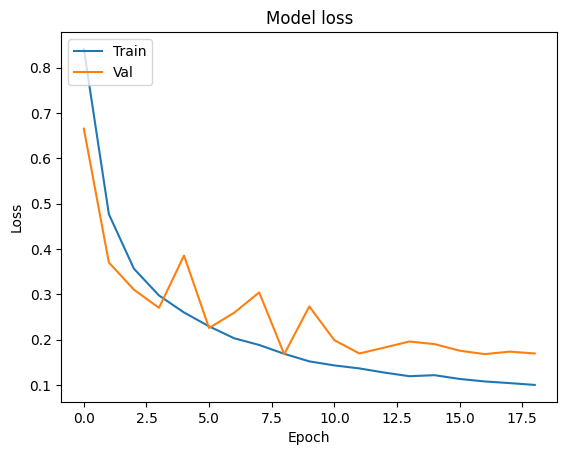

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

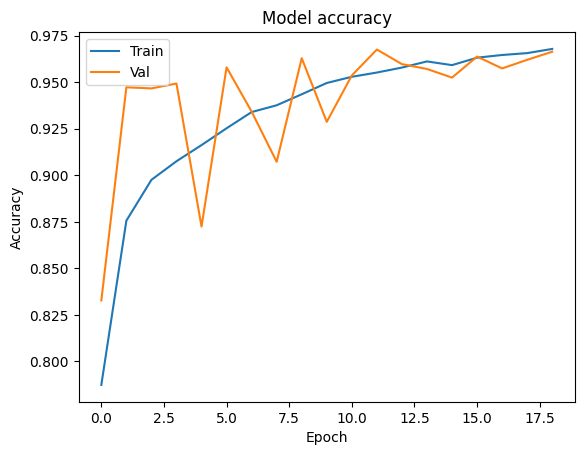

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [45]:
y_pred_probs = multi_head_model.predict([X_test_signals, X_test_images])
y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1311
           1       0.95      0.98      0.97      1403
           2       0.96      0.89      0.93       736

    accuracy                           0.96      3450
   macro avg       0.96      0.95      0.96      3450
weighted avg       0.96      0.96      0.96      3450



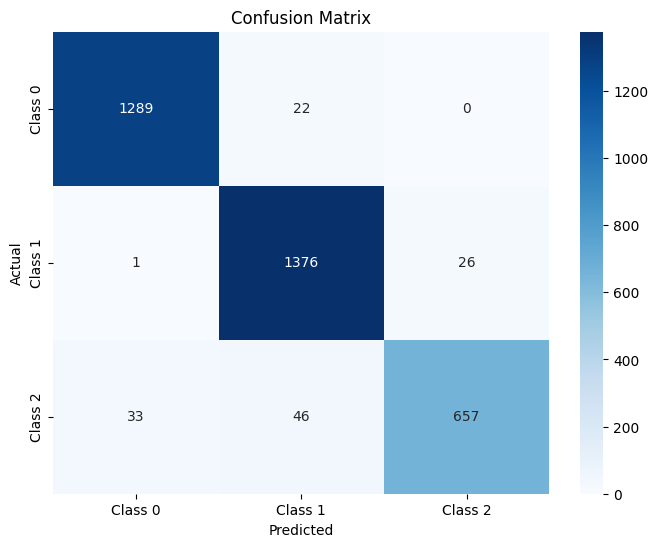

In [48]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()